# Run 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import joblib
from pickle import dump
from pandas import read_csv
from pickle import load

%matplotlib inline

In [2]:
from astroquery.ned import Ned
import astropy.units as u
from astropy import coordinates
from astropy.table import Table
import time
from astropy.coordinates import SkyCoord

In [3]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process.kernels import RBF

# PCA & data scaling

In [4]:
df_training =  pd.read_csv("training_v2_dr7.csv")
columnsNamesArr = df_training.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [5]:
print(df_training.groupby('category').size())


category
Contaminant       189
Known galaxies     18
dtype: int64


In [6]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [7]:
# classification as array of 0's and 1's
category = df_training['category']
classification = np.NaN*np.ones(len(category))
classification[category == 'Known galaxies'] = 1  
classification[category == 'Contaminant'] = 0 
print(len(classification))
print(len(classification[classification == 1]))

207
18


In [8]:
# define feature data and standardize it
data = df_training.loc[:,features].values
# define scaler
# scaler = StandardScaler()
scaler = RobustScaler()
# scaler = QuantileTransformer()
# fit scaler on the training dataset
scaler.fit(data)
# transform the training dataset
data_scaled = scaler.transform(data)

In [9]:
# transform data to 6 principle components which take into account 95 pct of the variance in the data
pca = PCA(n_components = 11, random_state = 2020)
pca.fit(data_scaled)
# pca = PCA(n_components = 0.95, random_state = 2020) this automatically chooses the amount of PC's for 95 pct variance
principal_components = pca.transform(data_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6','Principal Component 7','Principal Component 8','Principal Component 9','Principal Component 10','Principal Component 11'])
final_df = pd.concat([principal_df, df_training[['category']]], axis = 1)


Text(0.5, 1.0, 'Influence on each principal component by features')

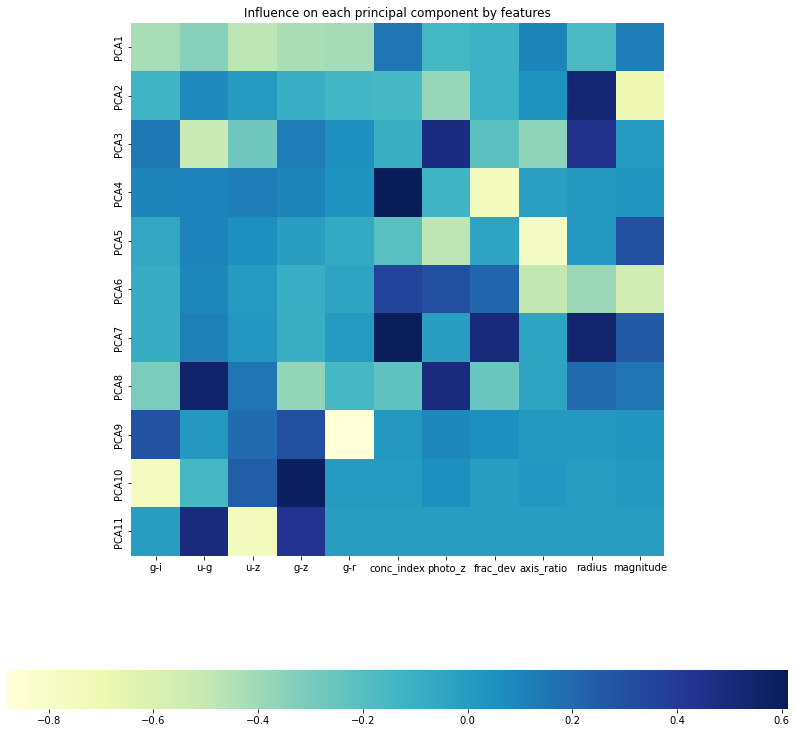

In [10]:
features_map = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'conc_index', 'photo_z', 'frac_dev', 'axis_ratio','radius', 'magnitude']
fig = plt.figure(figsize = (14,14))
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=features_map,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
ax.set_title('Influence on each principal component by features')

In [11]:
X = principal_components
y = classification

In [12]:
# X = data_scaled
# y = classification

In [13]:
# X = data
# y = classification

# Model training

In [14]:
# Spot Check Algorithms
random_state = 2020
models = []
models.append(('LR', LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state = 2020,gamma='auto')))
models.append(('GP', GaussianProcessClassifier(random_state = 2020)))
models.append(('RF', RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')))
models.append(('MLP', MLPClassifier(random_state = 2020,activation='relu', solver='lbfgs', max_iter=200)))
models.append(('PRCP', Perceptron(random_state = 2020, max_iter=30, tol = 0.001)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='recall')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# try neural network

LR: 0.112500 (0.113880)
LDA: 0.387500 (0.167239)
KNN: 0.337500 (0.119242)
CART: 0.500000 (0.070711)
NB: 0.112500 (0.113880)
SVM: 0.000000 (0.000000)
GP: 0.325000 (0.160078)
RF: 0.125000 (0.125000)
MLP: 0.587500 (0.230149)
PRCP: 0.550000 (0.231840)


In [14]:
eclf1 = DecisionTreeClassifier()
eclf1.fit(X,y)
eclf_predict = eclf1.predict(X)

In [15]:
# voting methods application
clf1 = LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')
clf2 = LinearDiscriminantAnalysis()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier()
clf5 = GaussianNB()
clf6 = GaussianProcessClassifier(random_state = 2020)
clf7 = SVC(random_state = 2020,gamma='auto')
clf8 = RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')
clf9 = MLPClassifier(random_state = 2020, activation='relu', solver='lbfgs', max_iter=100000)
clf10 = Perceptron(random_state = 2020, max_iter=30, tol = 0.001)

eclf1 = VotingClassifier(estimators=[('CART', clf4), ('MLP', clf9)], voting='hard')
eclf1.fit(X, y)
eclf_predict = eclf1.predict(X)

In [16]:
# # save the model
# dump(eclf1, open('voting_model_PCA_v1_dr7.pkl', 'wb'))
# # save the scaler
# dump(scaler, open('scaler_voting_model_PCA_v1_dr7.pkl', 'wb'))
# # save the pca
# dump(pca, open('pca_model_PCA_v1_dr7.pkl', 'wb'))

In [15]:
plt.rcParams.update({'font.size': 20})

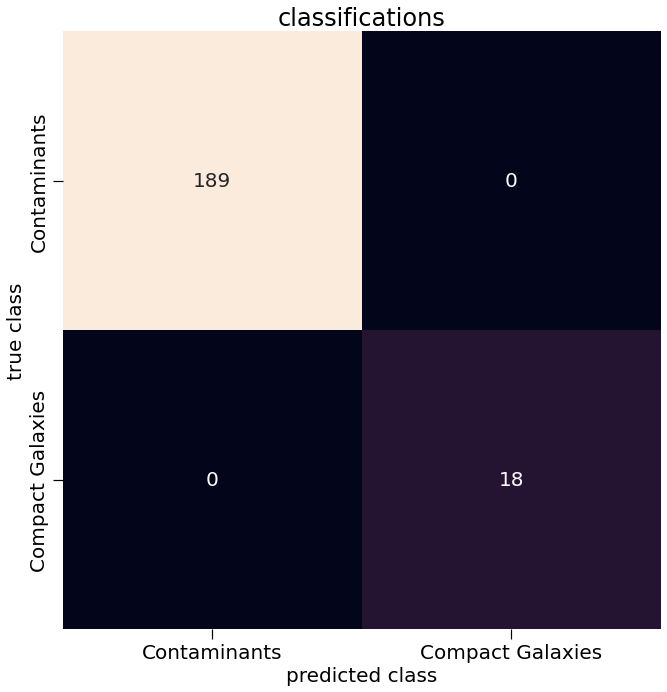

In [16]:
fig1 = plt.figure(figsize=(11,11))
g = sns.heatmap(confusion_matrix(y, eclf_predict), square=True, annot=True, fmt="d", cbar=False, xticklabels=['Contaminants', 'Compact Galaxies'], yticklabels=['Contaminants', 'Compact Galaxies'])
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('classifications')
plt.tick_params('both', length=10, width=1.2, which='major', labelsize=20)

# Model application on Atlas3D galaxies

In [19]:
df_atlas3d = pd.read_csv("atlas3d_search_dr7.csv")
columnsNamesArr = df_atlas3d.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [20]:
objid = df_atlas3d['objid']
ra, dec = df_atlas3d['ra'], df_atlas3d['dec']
host_galaxy = df_atlas3d['host_galaxy']
distance = df_atlas3d['distance']
magnitude = df_atlas3d['magnitude']
category = df_atlas3d['category']
radius = df_atlas3d['radius']
u_mag, g_mag, r_mag, i_mag, z_mag = df_atlas3d['u_mag'], df_atlas3d['g_mag'], df_atlas3d['r_mag'], df_atlas3d['i_mag'], df_atlas3d['z_mag']
concentration_index = df_atlas3d['concentration_index']
frac_dev = df_atlas3d['frac_dev']
axis_ratio = df_atlas3d['axis_ratio']
photoz = df_atlas3d['photo_z']
category = df_atlas3d['category']
g_i, u_g, u_z, g_z, g_r = df_atlas3d['g-i'], df_atlas3d['u-g'], df_atlas3d['u-z'], df_atlas3d['g-z'], df_atlas3d['g-r']
magnitude = df_atlas3d['magnitude']
radius = df_atlas3d['radius']

In [21]:
category[category == 'Possible contaminants'] = 'Possible compact galaxies'

C:\Users\Home\AppData\Local\Temp/ipykernel_5440/2455194359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category[category == 'Possible contaminants'] = 'Possible compact galaxies'


In [22]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [23]:
#make a link to sdss for this object
objid = np.array(objid)
link = []
for i in range(len(objid)):
    url = 'http://cas.sdss.org/dr7/en/tools/explore/obj.asp?id=' + str(objid[i])
    link.append(url)
link = np.array(link)

In [24]:
print(df_atlas3d.groupby('category').size())

category
Known galaxies                  18
Possible compact galaxies    18769
dtype: int64


In [25]:
#PCA
X = df_atlas3d.loc[:,features].values
X_scaled = scaler.transform(X)
X_pca_scaled = pca.transform(X_scaled)
y = eclf1.predict(X_pca_scaled) 

In [26]:
# #Scaled
# X = df_atlas3d.loc[:,features].values
# X_scaled = scaler.transform(X)
# # X_pca_scaled = pca.transform(X_scaled)
# y = eclf1.predict(X_scaled) 

In [27]:
# #Raw
# X = df_atlas3d.loc[:,features].values
# # X_scaled = scaler.transform(X)
# # X_pca_scaled = pca.transform(X_scaled)
# y = eclf1.predict(X) 

In [28]:
index_1a = np.where(y == 1)[0]
print('Voting method:', len(index_1a))
index_1b = np.where(y == 0)[0]

Voting method: 115


In [29]:
# dictionary of lists  
dict = {'objid': objid[index_1a], 'ra': ra[index_1a], 'dec': dec[index_1a], 'g-i': g_mag[index_1a] - i_mag[index_1a], 'u-g': u_mag[index_1a] - g_mag[index_1a], 'u-z': u_mag[index_1a] - z_mag[index_1a], 'g-z': g_mag[index_1a] - z_mag[index_1a], 'g-r': g_mag[index_1a] - r_mag[index_1a], 'concentration_index': concentration_index[index_1a], 'photo_z': photoz[index_1a], 'frac_dev': frac_dev[index_1a], 'host_galaxy': host_galaxy[index_1a], 'distance': distance[index_1a], 'axis_ratio': axis_ratio[index_1a], 'category': category[index_1a], 'radius': radius[index_1a], 'magnitude': magnitude[index_1a], 'u_mag': u_mag[index_1a], 'g_mag': g_mag[index_1a], 'i_mag': i_mag[index_1a], 'r_mag': r_mag[index_1a], 'z_mag': z_mag[index_1a],  'link': link[index_1a]}   
df_voting_results= pd.DataFrame(dict) 
    
# saving the dataframe 
df_voting_results.to_csv('voting_results_v2.csv', index = False) 

In [30]:
print(df_voting_results.groupby('category').size())
print('From a total of 871 host galaxies')

category
Known galaxies                15
Possible compact galaxies    100
dtype: int64
From a total of 871 host galaxies


# NED search for possible compact galaxies from 

In [31]:
objid_voting = df_voting_results['objid']
ra_voting, dec_voting = np.array(df_voting_results['ra']), np.array(df_voting_results['dec'])
host_galaxy_voting = df_voting_results['host_galaxy']
distance_voting = df_voting_results['distance']
magnitude_voting = df_voting_results['magnitude']
category_voting = df_voting_results['category']
radius_voting = df_voting_results['radius']
u_mag_voting, g_mag_voting, r_mag_voting, i_mag_voting, z_mag_voting = df_voting_results['u_mag'], df_voting_results['g_mag'], df_voting_results['r_mag'], df_voting_results['i_mag'], df_voting_results['z_mag']
concentration_index_voting = df_voting_results['concentration_index']
frac_dev_voting = df_voting_results['frac_dev']
axis_ratio_voting = df_voting_results['axis_ratio']
photoz_voting = df_voting_results['photo_z']
category_voting = df_voting_results['category']
g_i_voting, u_g_voting, u_z_voting, g_z_voting, g_r_voting = df_voting_results['g-i'], df_voting_results['u-g'], df_voting_results['u-z'], df_voting_results['g-z'], df_voting_results['g-r']
link_voting = df_voting_results['link']

In [32]:
name1 = []
ra1 = []
dec1 = []
velocity1 = []
redshift1 = []
flag1 = []
for i in range(len(ra_voting)):
    print(i)
#     if i%200 == 0:
#         time.sleep(15)
    co = coordinates.SkyCoord(ra=ra_voting[i], dec=dec_voting[i], unit=(u.deg, u.deg))
    results = Ned.query_region(co, radius=1* u.arcsec, equinox='J2000.0')
    if len(results) == 0:
        name1_temp, ra1_temp, dec1_temp, vel1_temp, redshift1_temp, flag1_temp = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        name1.append(name1_temp)
        ra1.append(ra1_temp)
        dec1.append(dec1_temp)
        velocity1.append(vel1_temp)
        redshift1.append(redshift1_temp)
        flag1.append(flag1_temp)
    else:
        name1_temp, ra1_temp, dec1_temp, vel1_temp, redshift1_temp, flag1_temp = results['Object Name'], results['RA'], results['DEC'], results['Velocity'], results['Redshift'], results['Redshift Flag']
        for j in range(len(name1_temp)):
            name1.append(name1_temp[j])
            ra1.append(ra1_temp[j])
            dec1.append(dec1_temp[j])
            velocity1.append(vel1_temp[j])
            redshift1.append(redshift1_temp[j])
            flag1.append(flag1_temp[j])

0
1
2


3
4
5
6
7
8
9
10
11

WARNING


12
13
14
15
16
17
18
19


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


20
21
22
23
24
25
26
27
28


29
30
31
32
33
34


35
36
37
38
39


40
41
42
43
44
45
46


47
48
49
50
51
52
53
54


55
56
57
58
59
60
61
62


63
64
65
66
67
68
69
70
71


72
73
74
75
76
77
78
79
80
81
82
83
84
85


86
87
88
89
90
91
92
93
94


95
96
97
98
99
100


101
102
103
104
105
106
107
108
109
110


111
112
113
114


In [33]:
# dictionary of lists  
dict = {'name': name1, 'ra': ra1, 'dec': dec1, 'velocity': velocity1, 'redshift': redshift1, 'flag': flag1}  
df_ned_voting = pd.DataFrame(dict) 
    
# saving the dataframe 
# df1.to_csv('ned_compact_dr7.csv') 

# NED (with specz > 0.01) and ML results crossmatching

In [34]:
ra_ned_voting, dec_ned_voting, name_ned_voting, velocity_ned_voting, redshift_ned_voting, flag_ned_voting = df_ned_voting['ra'], df_ned_voting['dec'], df_ned_voting['name'], df_ned_voting['velocity'], df_ned_voting['redshift'], df_ned_voting['flag']

In [35]:
redshift_ned_voting_1a = redshift_ned_voting.copy()
redshift_ned_voting_1a[redshift_ned_voting_1a == '--'] = np.nan
redshift_ned_voting_1a = redshift_ned_voting_1a.astype(float)

voting_specz_over = (redshift_ned_voting_1a > 0.01) & (flag_ned_voting == 'SPEC')

C:\Users\Home\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [36]:
ra_ned_voting_1 = np.array(ra_ned_voting[voting_specz_over])
dec_ned_voting_1 = np.array(dec_ned_voting[voting_specz_over])
name_ned_voting_1 =  np.array(name_ned_voting[voting_specz_over])
velocity_ned_voting_1 = np.array(velocity_ned_voting[voting_specz_over])
redshift_ned_voting_1 = np.array(redshift_ned_voting[voting_specz_over]).astype(float)
flag_ned_voting_1 = np.array(flag_ned_voting[voting_specz_over])

In [37]:
c1 = SkyCoord(ra=ra_voting*u.degree, dec=dec_voting*u.degree)
catalog1 = SkyCoord(ra=ra_ned_voting_1*u.degree, dec=dec_ned_voting_1*u.degree)
idx_1, d2d_1, d3d_1 = c1.match_to_catalog_sky(catalog1)

In [38]:
max_sep = 1 * u.arcsec
sep_constraint_1 = d2d_1 < max_sep
c1_matches = c1[sep_constraint_1]
catalog1_matches = catalog1[idx_1[sep_constraint_1]]

In [39]:
objid_training = df_training['objid']
ra_training, dec_training = df_training['ra'], df_training['dec']
host_galaxy_training = df_training['host_galaxy']
distance_training = df_training['distance']
magnitude_training = df_training['magnitude']
category_training = df_training['category']
radius_training = df_training['radius']
u_mag_training, g_mag_training, r_mag_training, i_mag_training, z_mag_training = df_training['u_mag'], df_training['g_mag'], df_training['r_mag'], df_training['i_mag'], df_training['z_mag']
concentration_index_training = df_training['concentration_index']
frac_dev_training = df_training['frac_dev']
axis_ratio_training = df_training['axis_ratio']
photoz_training = df_training['photo_z']
category_training = df_training['category']
g_i_training, u_g_training, u_z_training, g_z_training, g_r_training = df_training['g-i'], df_training['u-g'], df_training['u-z'], df_training['g-z'], df_training['g-r']
link_training = df_training['link']

In [40]:
category_voting[sep_constraint_1] = 'Contaminant'

C:\Users\Home\AppData\Local\Temp/ipykernel_5440/354860432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_voting[sep_constraint_1] = 'Contaminant'


# Creating new training data:
## Adding original training set + NED confirmed contaminants

In [41]:
objid_final = np.concatenate((objid_training,objid_voting[sep_constraint_1]))
ra_final, dec_final = np.concatenate((ra_training,ra_voting[sep_constraint_1])), np.concatenate((dec_training,dec_voting[sep_constraint_1]))
host_galaxy_final = np.concatenate((host_galaxy_training,host_galaxy_voting[sep_constraint_1]))
distance_final = np.concatenate((distance_training,distance_voting[sep_constraint_1]))
magnitude_final = np.concatenate((magnitude_training,magnitude_voting[sep_constraint_1]))
category_final = np.concatenate((category_training,category_voting[sep_constraint_1]))
radius_final = np.concatenate((radius_training,radius_voting[sep_constraint_1]))
u_mag_final, g_mag_final, r_mag_final, i_mag_final, z_mag_final = np.concatenate((u_mag_training,u_mag_voting[sep_constraint_1])), np.concatenate((g_mag_training,g_mag_voting[sep_constraint_1])), np.concatenate((r_mag_training,r_mag_voting[sep_constraint_1])), np.concatenate((i_mag_training,i_mag_voting[sep_constraint_1])), np.concatenate((z_mag_training,z_mag_voting[sep_constraint_1]))
concentration_index_final = np.concatenate((concentration_index_training,concentration_index_voting[sep_constraint_1]))
frac_dev_final = np.concatenate((frac_dev_training,frac_dev_voting[sep_constraint_1]))
axis_ratio_final = np.concatenate((axis_ratio_training,axis_ratio_voting[sep_constraint_1]))
photoz_final = np.concatenate((photoz_training,photoz_voting[sep_constraint_1]))
category_final = np.concatenate((category_training,category_voting[sep_constraint_1]))
g_i_final, u_g_final, u_z_final, g_z_final, g_r_final = np.concatenate((g_i_training,g_i_voting[sep_constraint_1])), np.concatenate((u_g_training,u_g_voting[sep_constraint_1])), np.concatenate((u_z_training,u_z_voting[sep_constraint_1])), np.concatenate((g_z_training,g_z_voting[sep_constraint_1])), np.concatenate((g_r_training,g_r_voting[sep_constraint_1]))
link_final = np.concatenate((link_training,link_voting[sep_constraint_1]))

In [42]:
# dictionary of lists  
dict = {'objid': objid_final, 'ra': ra_final, 'dec': dec_final, 'g-i': g_i_final, 'u-g': u_g_final, 'u-z': u_z_final, 'g-z': g_z_final, 'g-r': g_r_final, 'concentration_index': concentration_index_final, 'photo_z': photoz_final, 'frac_dev': frac_dev_final, 'host_galaxy': host_galaxy_final, 'distance': distance_final, 'axis_ratio': axis_ratio_final, 'category': category_final, 'radius': radius_final, 'magnitude': magnitude_final, 'u_mag': u_mag_final, 'g_mag': g_mag_final, 'i_mag': i_mag_final, 'r_mag': r_mag_final, 'z_mag': z_mag_final,  'link': link_final}  
df_training_v3= pd.DataFrame(dict) 
    
# saving the dataframe 
df_training_v3.to_csv('training_v3_dr7.csv') 

In [43]:
print(df_training_v3 .groupby('category').size())

category
Contaminant       196
Known galaxies     18
dtype: int64
